## Review regression outputs for PR410

This notebook uses the reselected pkl files made with make-regression-data.ipynb.

The pickle files over a date range for dir1 (master and last release) and dir2 (current PR output) are reviewed for diffs.

For each diff, the logs and other metadata are reviewed to infer if the catalog change is likely reasonable based on new guide candidate / fid light optimization.

In [ ]:
import kadi.commands as kc
from cxotime import CxoTime
from astropy.table import Table
import astropy.units as u
from pathlib import Path
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dir1 = "regression_data/5.17.2.dev1+g6fa410d_4.31.0" # generated from the opt-log branch
dir2 = "regression_data/5.17.2.dev51+ge5ee6d8_4.31.0" # from guide-opt-fid branch

In [3]:

# Get the last 2.5 years of approved schedules
obss = kc.get_observations("2023-07-04", "2025-12-30")
obss = [obs for obs in obss if obs["source"] != "CMD_EVT"]
load_names = []
[load_names.append(obs["source"]) for obs in obss if obs["source"] not in load_names];


In [4]:
load_names[0]

'JUL0323A'

In [5]:
load_names[-1]

'DEC2925B'

In [6]:
from proseco.diff import catalog_diff

This method checks the new "fid_trap_spoiler" flag in the fid candidate table to see if one or more of the candidate fids could have been spoiled by a guide star and its relationship to the fid trap.

This method also checks the selection logs to see if any fid lights were removed from candidacy because they would spoil guide star candidate(s) (not via fid trap issue).

The intent with the method was just to scan all of the new pkl files and their proseco catalogs to confirm that each change corresponded to at least one of those kinds of changes and throw an exception otherwise.  The method did not throw any exceptions.

In [7]:
def review_cat(cat1, cat2):
    cdiff = catalog_diff(cat1, cat2, style="unified")
    if len(cat1.fids) == 0 and len(cat2.fids) == 0:
        if cdiff.text != "":
            raise ValueError("No fids but catalog diff")
        return None
    trap_spoiler = np.any(cat2.fids.cand_fids["fid_trap_spoiler"])
    direct_guide_spoiler = np.any([entry["data"].endswith("spoils a guide candidate") for entry in cat2.fids.log_info["events"]])
    if cdiff.text == "":
        return None
    elif trap_spoiler and direct_guide_spoiler:
        return "Both trap and direct guide spoilers"
    elif trap_spoiler:
        return "Trap spoiler"
    elif direct_guide_spoiler:
        return "Direct guide spoiler"
    else:
        raise ValueError("Diff text but no obvious cause")


In [8]:
from collections import defaultdict

In [9]:
counts = defaultdict(int)
for load_name in load_names:
    pkl1 = Path(f"{dir1}/{load_name}_acas.pkl.gz")
    pkl2 = Path(f"{dir2}/{load_name}_acas.pkl.gz")
    if not (pkl1.exists() and pkl2.exists()):
        continue
    acas1 = pickle.load(gzip.open(pkl1, "rb"))
    acas2 = pickle.load(gzip.open(pkl2, "rb"))
    for obsid in acas1.keys():
        cmp = review_cat(acas1[obsid], acas2[obsid])
        if cmp is not None:
            counts[cmp] = counts[cmp] + 1
        else:
            counts["no_diff"] = counts["no_diff"] + 1


The review of the data shows that in most cases (~90%) there is no change in the catalog, but in the other 10% of cases, the use of the guide star information does change the fid selection and the resulting catalog (either because of the fid trap effect or because the fid would be within a guide star search/track region). 

In [10]:
counts

defaultdict(int,
            {'no_diff': 6122,
             'Trap spoiler': 557,
             'Direct guide spoiler': 66,
             'Both trap and direct guide spoilers': 39})

In the next chunk of code, we review how the P2 and guide count behave in the catalogs that have changed.

In [11]:
compare = []
for load_name in load_names:
    pkl1 = Path(f"{dir1}/{load_name}_acas.pkl.gz")
    pkl2 = Path(f"{dir2}/{load_name}_acas.pkl.gz")
    if not (pkl1.exists() and pkl2.exists()):
        continue
    acas1 = pickle.load(gzip.open(pkl1, "rb"))
    acas2 = pickle.load(gzip.open(pkl2, "rb"))
    for obsid in acas1.keys():
        cmp = review_cat(acas1[obsid], acas2[obsid])
        if cmp is not None:
            # What are the p2 and guide_count of the original and new catalog?
            acar1 = acas1[obsid].get_review_table()
            guide_count_1 = acar1.guide_count
            acar2 = acas2[obsid].get_review_table()
            guide_count_2 = acar2.guide_count
            p2_1 = -np.log10(acar1.acqs.calc_p_safe())
            p2_2 = -np.log10(acar2.acqs.calc_p_safe())
            compare.append((load_name, obsid, cmp, guide_count_1, guide_count_2, p2_1, p2_2))


In [17]:
# Oops, should made that easier to Table
compare_list_of_dicts = []
for row in compare:
    compare_list_of_dicts.append({
        "load_name": row[0],
        "obsid": row[1],
        "diff_type": row[2],
        "guide_count_1": row[3],
        "guide_count_2": row[4],
        "p2_1": row[5],
        "p2_2": row[6],
    })

In [ ]:

dat = Table(compare_list_of_dicts)

The 4 plots in the cells below show that the P2 is overwhelmingly unchanged, but in a few cases is a bit worse.  The guide_count is generally the same or better.  This is not unexpected as the PR now includes the guide candidates in the fid selection process (biasing an improvement in guide_count) and it is not surprising that, with the current optimization strategy, a P2 value lower than the previous estimate could be picked, especially if that P2 value is > 2.0 (the passable threshold in the optimization logic).

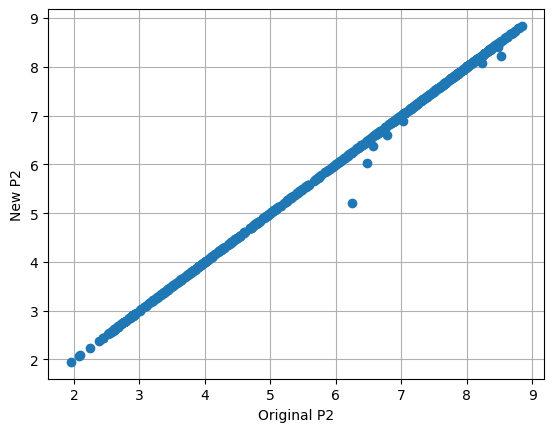

In [ ]:
plt.plot(dat['p2_1'], dat['p2_2'], 'o')
plt.xlabel('Original P2')
plt.ylabel('New P2')
plt.grid(True)

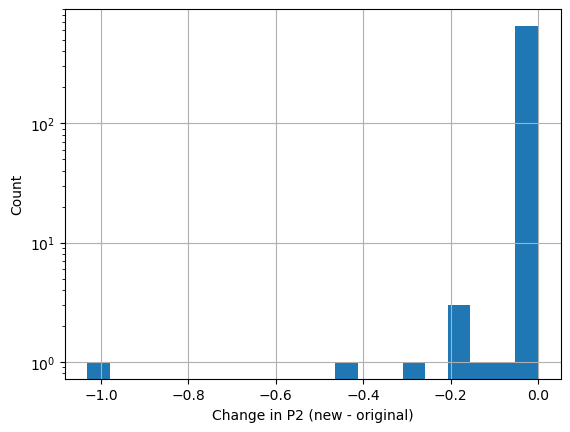

In [41]:
plt.hist(dat["p2_2"] - dat["p2_1"], bins=20, log=True);
plt.xlabel('Change in P2 (new - original)')
plt.ylabel('Count')
plt.grid(True)

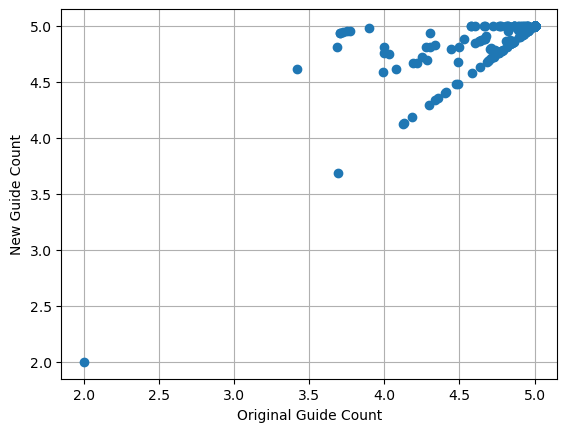

In [26]:

plt.plot(dat["guide_count_1"], dat["guide_count_2"], 'o')
plt.xlabel('Original Guide Count')
plt.ylabel('New Guide Count')
plt.grid(True)

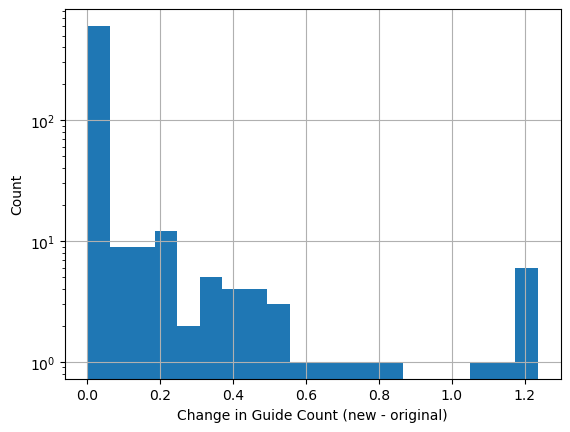

In [42]:
plt.hist(dat["guide_count_2"] - dat["guide_count_1"], bins=20, log=True);
plt.xlabel('Change in Guide Count (new - original)')
plt.ylabel('Count')
plt.grid(True)

In [43]:
import re
def get_n_optimizations(aca):
    for event in aca.log_info["events"]:
        m = re.search(r'.*N opt runs=(\d+)', event['data'])
        if m:
            return int(m.group(1))
    return 0


Here we've again scanned all of the new pkl catalogs and checked to see which actually got to catalog "optimization" *caused* by this PR.  While doing that review, this also counts up the catalogs with optimization that is not new and looks for weird cases (optimized without this PR and not optimized with this PR code).

In [44]:
guide_opt_counts = []
opt_counts = []
weird_counts = []
for load_name in load_names:
    pkl1 = Path(f"{dir1}/{load_name}_acas.pkl.gz")
    pkl2 = Path(f"{dir2}/{load_name}_acas.pkl.gz")
    if not pkl1.exists():
        print(f"Skipping {load_name} missing pkl1")
        continue
    if not pkl2.exists():
        print(f"Skipping {load_name} missing pkl")
        continue
    acas2 = pickle.load(gzip.open(pkl2, "rb"))
    acas1 = pickle.load(gzip.open(pkl1, "rb"))
    for obsid in acas2.keys():
        if obsid > 38000:
            continue
        new_aca1 = acas1[obsid]
        new_aca2 = acas2[obsid]
        n_opt1 = get_n_optimizations(new_aca1)
        n_opt2 = get_n_optimizations(new_aca2)
        if n_opt2 > 1 and n_opt1 <= 1:
            guide_opt_counts.append((load_name, obsid, n_opt2))
        if n_opt2 > 1 and n_opt1 > 1:
            opt_counts.append((load_name, obsid, n_opt1, n_opt2))
        if n_opt1 > 1 and n_opt2 <= 1:
            weird_counts.append((load_name, obsid, n_opt1))


It looks like there are no weird cases

In [45]:
weird_counts

[]

It looks like the "worst" case was in obsid 28280 where with the new guide count and fid spoiling information the optimization needed to run 10 different fid sets to get to one that either satisfied the requirements or had the closest P2 to the no-fid P2.  Given the frequency of needing to dig that deep into optimization, this seems reasonable.

The list of tuples is week, obsid, number of optimization attempts.

In [46]:
guide_opt_counts

[('JUN1024A', np.float64(26571.0), 2),
 ('JUN1124A', np.float64(26571.0), 2),
 ('AUG1224A', np.float64(28280.0), 10),
 ('OCT0724A', np.float64(28382.0), 2),
 ('DEC0924A', np.float64(30674.0), 2),
 ('DEC1024A', np.float64(30674.0), 2),
 ('JUL2125A', np.float64(31009.0), 4)]

The fraction of *extra* optimization due to the new information seems reasonable.  Below are just the optimization counts for obsids before the guide star information was used.  The data structure there is just week, obsid, number of previous optimization attempts, number of current optimization attempts.

In [47]:
opt_counts

[('AUG2123A', np.float64(24782.0), 4, 4),
 ('AUG2123A', np.float64(28488.0), 4, 4),
 ('FEB2624A', np.float64(26650.0), 4, 4),
 ('JUL0124A', np.float64(29472.0), 4, 4),
 ('SEP2324A', np.float64(29899.0), 2, 2),
 ('DEC0224A', np.float64(27983.0), 4, 4),
 ('DEC0224A', np.float64(27979.0), 4, 4),
 ('FEB0325A', np.float64(25501.0), 2, 2),
 ('FEB0325A', np.float64(25505.0), 4, 4),
 ('FEB2425A', np.float64(30284.0), 4, 3),
 ('JUN2325A', np.float64(28777.0), 4, 4),
 ('JUL1425A', np.float64(29577.0), 2, 2),
 ('AUG0425A', np.float64(30446.0), 4, 4),
 ('SEP1525A', np.float64(30136.0), 3, 3)]